# Problem 2 (a)

In [1]:
# Import libraries
import numpy as np 
import matplotlib.pyplot as plt

num_s = 50

P = np.zeros((num_s, num_s))

P[0, 0] = 1/2  # p(s1|s1)
P[1, 0] = 1/2  # p(s1|s2)
P[-1, -1] = 1/2  # p(s50|s50)
P[-2, -1] = 1/2  # p(s49|s50)

for i in range(1,49): # 2 =< i =< 48
    P[i-1][i] = 1/3
    P[i][i] = 1/3
    P[i+1][i] = 1/3 

I = np.eye(num_s)
p = np.linalg.inv((I - P))  # col 
p_a = p[:,0] / np.sum(p[:,0]) # col
print("Stationary probabilities:", p_a)

total_probability = np.sum(p_a)
print("Total probability:", total_probability)


Stationary probabilities: [0.01351351 0.02027027 0.02027027 0.02027027 0.02027027 0.02027027
 0.02027027 0.02027027 0.02027027 0.02027027 0.02027027 0.02027027
 0.02027027 0.02027027 0.02027027 0.02027027 0.02027027 0.02027027
 0.02027027 0.02027027 0.02027027 0.02027027 0.02027027 0.02027027
 0.02027027 0.02027027 0.02027027 0.02027027 0.02027027 0.02027027
 0.02027027 0.02027027 0.02027027 0.02027027 0.02027027 0.02027027
 0.02027027 0.02027027 0.02027027 0.02027027 0.02027027 0.02027027
 0.02027027 0.02027027 0.02027027 0.02027027 0.02027027 0.02027027
 0.02027027 0.01351351]
Total probability: 0.9999999999999998


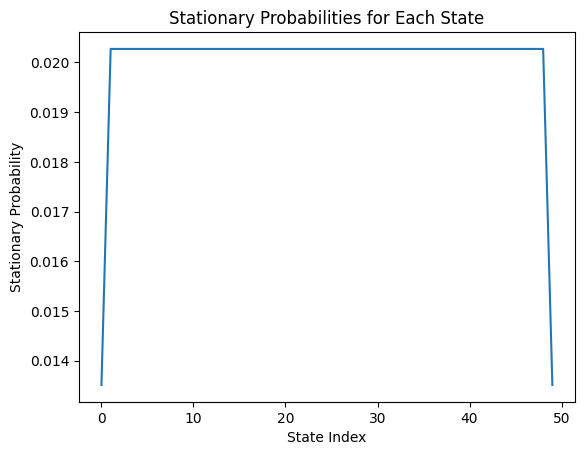

In [2]:

state_indices = np.arange(len(p_a))
plt.plot(p_a)
plt.xlabel('State Index')
plt.ylabel('Stationary Probability')
plt.title('Stationary Probabilities for Each State')
plt.show()

# Problem 2 (b)

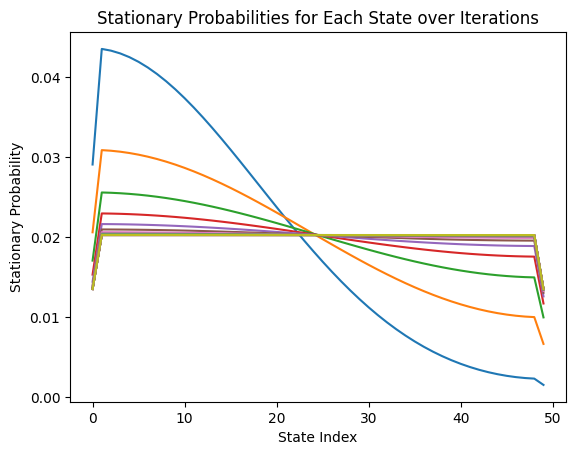

In [3]:
# Initialize p_b with first element as 1 and rest as 0
p_b = np.zeros((num_s))
p_b[0] = 1

# Lists to store stationary probabilities for each iteration
stationary_p = []

# Iterate to obtain the stationary probabilities
for n in range(10000):
    p_b = np.matmul(P, p_b)
    if n % 500 == 0:
        stationary_p.append(p_b)

stationary_p_array = np.array(stationary_p)

# Plot every 500 iterations 
for i in range(stationary_p_array.shape[0]):
    # start graph from n = 2 for visualization reasons as n = 1 is too far from the rest
    if(i == 0): continue
    plt.plot(stationary_p_array[i])

# Add the labels and the title
plt.xlabel('State Index')
plt.ylabel('Stationary Probability')
plt.title('Stationary Probabilities for Each State over Iterations')
plt.show()

### Compare the results of p_a and p_b

In [4]:
### We obtain the same result using either method
print(np.round(p_b-p_a))

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]


# Problem 6 from the book 4-7: Jack's Car Rental 


### We have two versions of the problem, first to check the result is correct for the original problem we can set problem_type to "original", and if we want to get the actual 4-7 solution, we can set it to "modified"

In [5]:
# Import libraries
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools


# Set up parameters
class problem_parameters:
    def __init__(self):

        # Discount rate
        self.gamma = 0.9
        # Cost of moving a car from one lot to other
        self.a_car_cost = 2
        # Reward
        self.car_reward = 10
        # Cost to keep over 10 cars at night
        self.night_slot_cost = 4
        # Max number of cars we can relocate per night
        self.max_car_rel = 5
        # Max number of cars per lot
        self.max_num_cars = 20

        # Small number to determine Policy iteration algorithm accuracy
        self.theta = 0.01
        # Expectated rental requests in first location
        self.lambda_first_req = 3
        # Expectated rental requests in second location
        self.lambda_second_req = 4
        # Expectated rental returns in first location
        self.lambda_first_return = 3
        # Expectated rental returns in second location
        self.lambda_second_return = 2


# Funtion to make figure for V
def get_figure_for_V(params, value_function):

    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    X = np.arange(0, params.max_num_cars + 1)
    Y = np.arange(0, params.max_num_cars + 1)
    X, Y = np.meshgrid(X, Y)
    ax.plot_surface(X, Y, value_function)
    plt.title("V")


# Funtion to make figure for every pi
def get_figure_for_pi_list(params, pi_list):

    for idx, pi in enumerate(pi_list):
        plt.figure()
        plt.imshow(pi, origin="lower", interpolation="none", vmin=-params.max_car_rel, vmax=params.max_car_rel)
        plt.xlabel("#Cars at second location")
        plt.ylabel("#Cars at first location")
        plt.title("$\pi_{{{}}}$".format(idx))
        plt.colorbar()


# Policy Iteration algorithm
class Policy_Iteration_Algorithm:

    def __init__(self, params, problem_type):
        # Set up the problem type
        self.problem_type = problem_type
        # Set up parameters
        self.params = params
        # Initialize a list of for Policy functions
        self.pi_list = []
        # Declare a 21x21 array for Policy function
        self.pi = np.zeros((self.params.max_num_cars + 1, self.params.max_num_cars + 1))
        # Declare a 21x21 array for Value function
        self.V = np.zeros((self.params.max_num_cars + 1, self.params.max_num_cars + 1))
        # Declare an array for all possible states
        self.S = list(itertools.product(range(self.params.max_num_cars + 1), repeat=2))

    def main_Policy_Iteration(self):
        # The main loop of policy iteration occurs here
        # We continuously perform Policy evaluation and Iteration as per the algorithm
        i = 0
        while True:
            print("Number of Iteration", i + 1)

            # Policy evaluation
            self.pi_list.append(self.pi.copy())
            while True:
                delta = 0
                for s in self.S:
                    v = self.V[s]
                    self.V[s] = self.get_V_s(s, self.pi[s])
                    delta = np.maximum(delta, abs(v - self.V[s]))
                if delta < self.params.theta:
                    break
                # print("Delta", delta)

            # Policy improvement
            pi_stable = True
            for s in self.S:
                old_action = self.pi[s]
                v_func = {a: self.get_V_s(s, a) for a in self.get_a_for_s(s)}
                self.pi[s] = np.random.choice(
                    [a for a, value in v_func.items() if value == np.max(list(v_func.values()))]
                )
                if old_action != self.pi[s]:
                    pi_stable = False

            if pi_stable:
                break

            i += 1

        return self.V, self.pi_list

    # Function to compute value function of current state and action
    def get_V_s(self, s, a):

        # Initialize value of state s as  0
        v_s = 0
        # Get current state for each one of the park lots
        lot_1_s, lot_2_s = s
        # Take an action for the first lot
        lot_1_s -= int(a)
        # Take an action for the second lot
        lot_2_s += int(a)

        # Compute the cost of the taken actions
        if self.problem_type == "original":
            cost = self.params.a_car_cost * abs(a)
        else:
            if a > 0:
                a -= 1
            cost = self.params.a_car_cost * abs(a) + self.params.night_slot_cost * (
                1 if lot_1_s > self.params.max_num_cars / 2 else 0 + 1 if lot_2_s > self.params.max_num_cars / 2 else 0
            )

        # Compute probability, reward, and value of the every possible next state
        sum_prob_i = 0

        # For the states for the first parking lot
        for i in range(lot_1_s + 1):

            if i == lot_1_s:
                p_i = 1 - sum_prob_i
            else:
                # Compute probability using Poisson distribution
                p_i = Policy_Iteration_Algorithm.poisson(self.params.lambda_first_req, i)
                sum_prob_i += p_i

            # Compute the reward
            r_i = i * self.params.car_reward
            sum_prob_j = 0

            # For the states for the second parking lot
            for j in range(lot_2_s + 1):

                if j == lot_2_s:
                    p_j = 1 - sum_prob_j

                else:
                    # Compute probability using Poisson distribution
                    p_j = Policy_Iteration_Algorithm.poisson(self.params.lambda_second_req, j)
                    sum_prob_j += p_j

                # Compute the reward
                r_j = j * self.params.car_reward
                sum_prob_k = 0

                for k in range(self.params.max_num_cars + i - lot_1_s + 1):
                    if k == self.params.max_num_cars + i - lot_1_s:
                        p_k = 1 - sum_prob_k
                    else:
                        # Compute probability using Poisson distribution
                        p_k = Policy_Iteration_Algorithm.poisson(self.params.lambda_first_return, k)
                        sum_prob_k += p_k
                    sum_prob_l = 0
                    for l in range(self.params.max_num_cars + j - lot_2_s + 1):
                        if l == self.params.max_num_cars + j - lot_2_s:
                            p_l = 1 - sum_prob_l
                        else:
                            # Compute probability using Poisson distribution
                            p_l = Policy_Iteration_Algorithm.poisson(self.params.lambda_second_return, l)
                            sum_prob_l += p_l

                        # Value evaluation formula (as in the algorithm in the course textbook page 80)
                        # sum over all s',r of p(s',r|s, a)[r + gamma*V(s')]
                        v_s += (
                            p_i
                            * p_j
                            * p_k
                            * p_l
                            * (r_i + r_j - cost + self.params.gamma * self.V[lot_1_s - i + k, lot_2_s - j + l])
                        )

        return v_s

    # Function to obtain all the possible actions for a state s
    def get_a_for_s(self, s):

        # List of actions for a state s
        a_for_s = []

        # All possible actions
        A = np.arange(-self.params.max_car_rel, self.params.max_car_rel + 1)
        slot_1_s, slot_2_s = s

        # Filter actions:
        # if makes negative or higher than max in any lot -> not include
        a_for_s = A[
            (slot_1_s - A >= 0)
            & (slot_1_s - A <= self.params.max_num_cars)
            & (slot_2_s + A >= 0)
            & (slot_2_s + A <= self.params.max_num_cars)
        ]

        return a_for_s

    @staticmethod
    def poisson(input_lambda, n):
        return (input_lambda**n) * math.exp(-input_lambda) / math.factorial(n)


def jacks_car_rental_4_7(problem_type):
    print("Jacks car rental (4.7)")

    # Set up parameters
    parameters = problem_parameters()

    for problem_type in problem_type:

        print(problem_type, "Problem")
        policy_iteration = Policy_Iteration_Algorithm(parameters, problem_type)
        value_function, pi_list = policy_iteration.main_Policy_Iteration()
        get_figure_for_pi_list(parameters, pi_list)
        get_figure_for_V(parameters, value_function)


### Above is the code for the Jack's Car Rental Problem
### Below we will see the results for the original problem first and then the 4-7 
### First, for the original

Jacks car rental (4.7)
original Problem
Number of Iteration 1
Number of Iteration 2
Number of Iteration 3
Number of Iteration 4
Number of Iteration 5


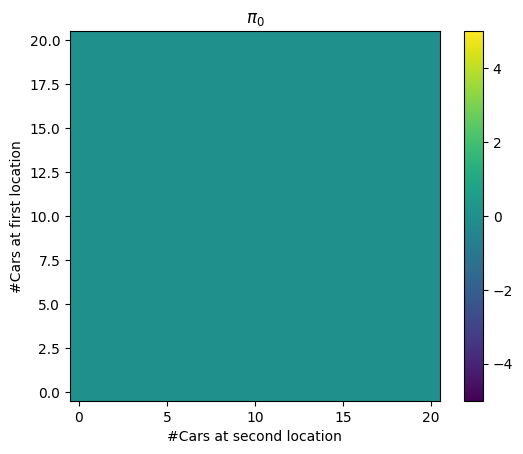

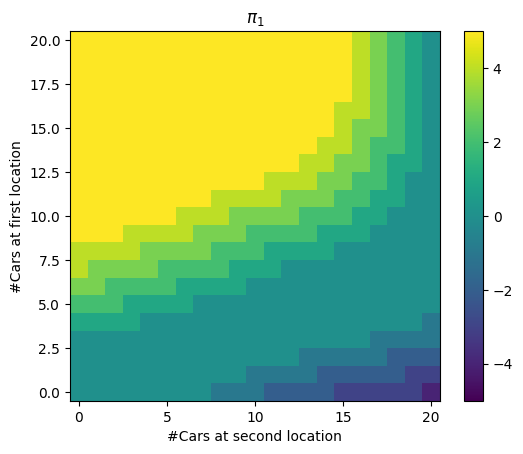

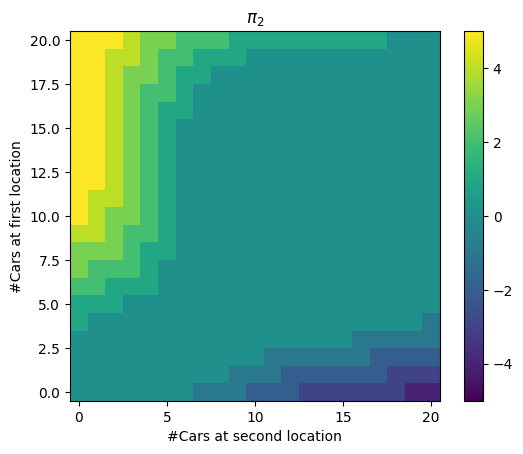

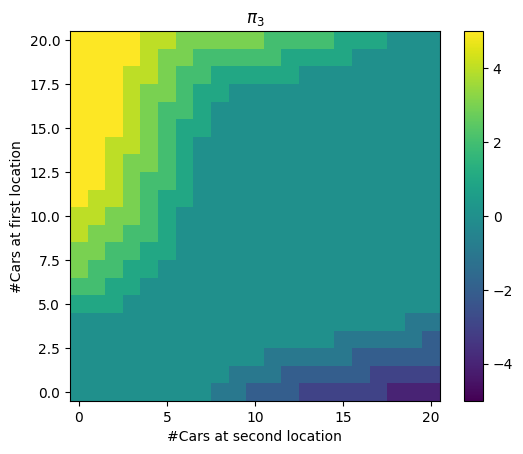

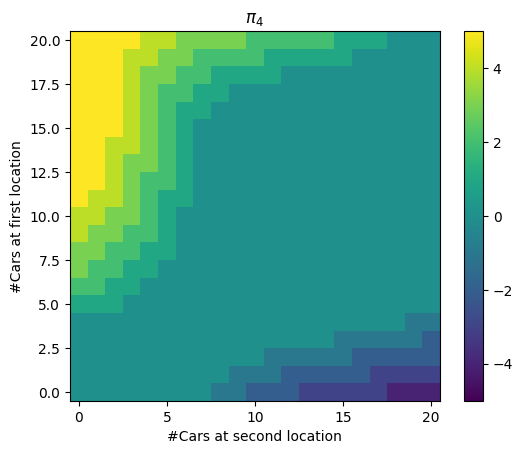

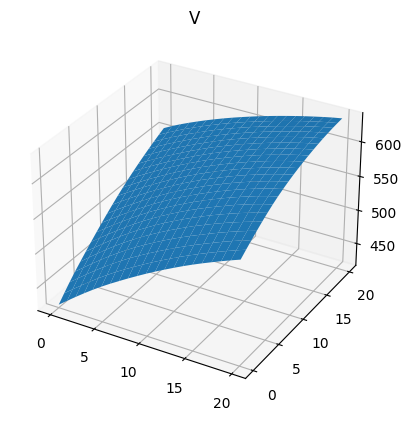

In [6]:
### Comment for TA: if you like you can skip this one and run the next one instead
# Set problem to "original" for the version of example 4-2

problem_type = ["original"]
jacks_car_rental_4_7(problem_type)
plt.show()

## Then the solution for 4-7 (Answer)

Jacks car rental (4.7)
modified Problem
Number of Iteration 1
Number of Iteration 2
Number of Iteration 3
Number of Iteration 4
Number of Iteration 5


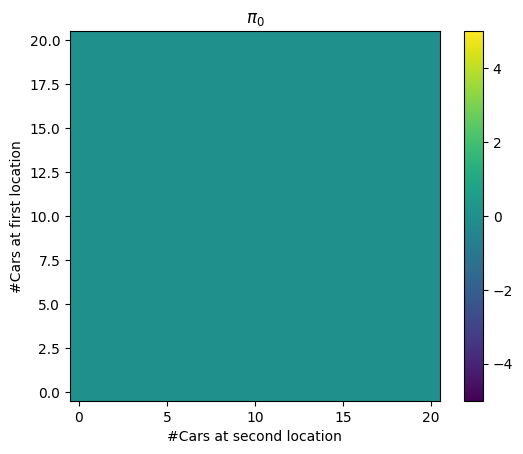

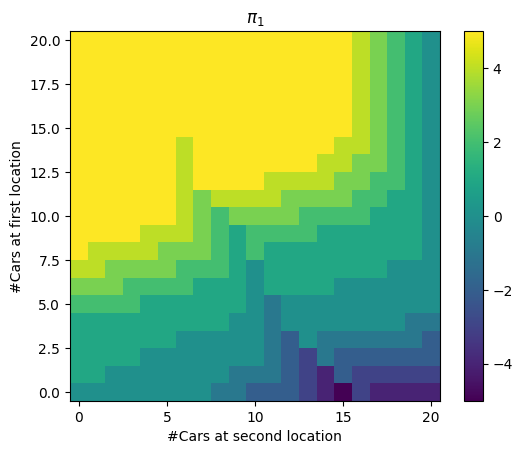

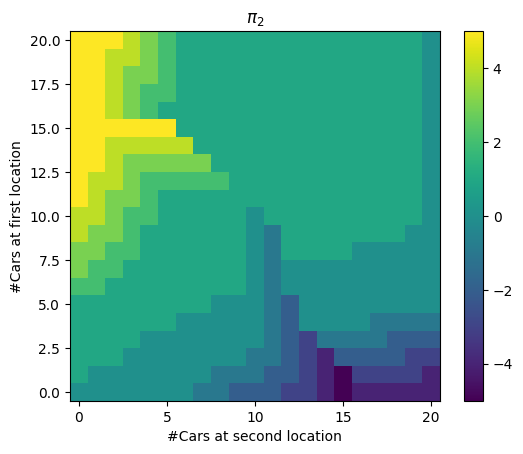

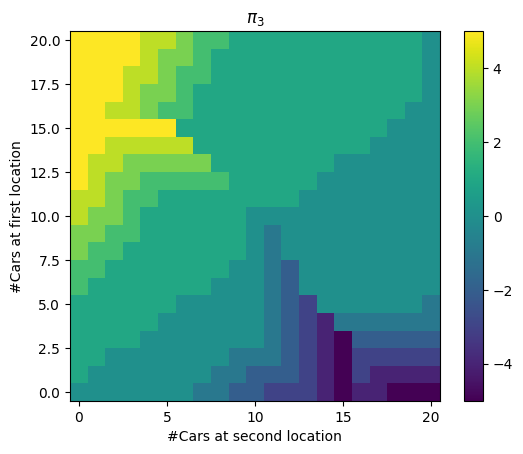

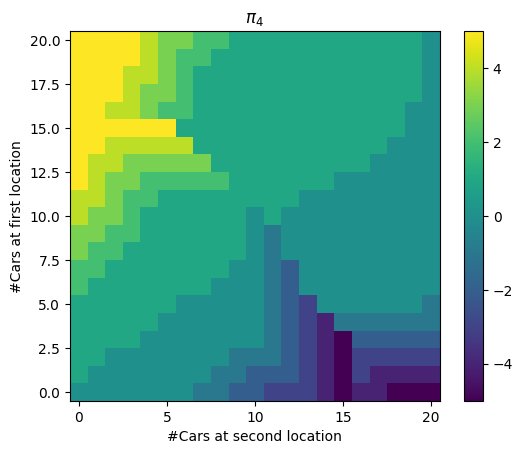

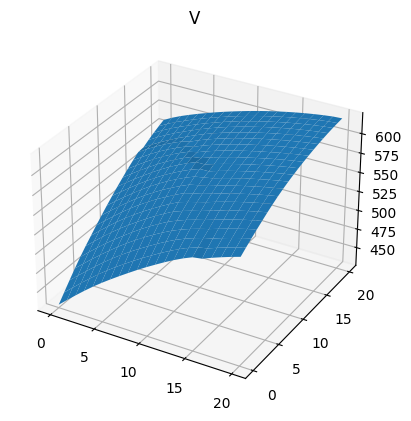

In [7]:
### Comment for TA: Please make sure to run this one
# Set problem to "modified" for the 4.7 formulation

problem_type = ["modified"]
jacks_car_rental_4_7(problem_type)
plt.show()